In [1]:
from langchain_community.document_loaders import PyPDFLoader, UnstructuredPDFLoader

/Users/hanhtet/Documents/workspace/multi-rag-syspare/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# configurations
# pdf = "test/testing_ocr.pdf" # ocr with i love pdf
pdf = "test/testing_ocr_sec.pdf" # ocr with pdf24 tools

In [3]:
# loader pdf
loader = PyPDFLoader(pdf)

In [4]:
docs = loader.load()
print(f"Loaded {len(docs)} documents from {pdf}")

Loaded 27 documents from test/testing_ocr_sec.pdf


In [5]:
tables = [d.metadata.get("tables", []) for d in docs]
texts = [d.page_content for d in docs]

In [6]:
# check for the first document in each set
print("\nFirst document from loader_fir:")
print(f"Text: {texts[0][:200]}...")
print(f"Tables: {tables[0]}")


First document from loader_fir:
Text: INTRODUCTION 
Thank you for purchasing Yanmar tractor product that has been designed and 
manufactured based on the Yanmar state-of-the-art technology and rich 
expertise in developing and manufacturi...
Tables: []


In [7]:
print(f"Loader text count: {len(texts)}")

Loader text count: 27


In [8]:
import nltk, re
nltk.download("words")

[nltk_data] Downloading package words to /Users/hanhtet/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [9]:
# Load a set of valid English words
from nltk.corpus import words
valid_words = set(words.words())

def clean_text(text):
    text = re.sub(r'[^\w\s]', '', text) # Remove unwanted characters (e.g., special symbols)
    text = re.sub(r'\s+', ' ', text).strip() # Normalize whitespace
    text = ' '.join(word for word in text.split() if word.lower() in valid_words) # Filter out unreadable or meaningless words
    return text

cleaned_texts = [clean_text(t) for t in texts]

# cleaned_texts_fallback_fir = [clean_text(t) for t in texts_fallback_fir]
# cleaned_texts_fallback_sec = [clean_text(t) for t in texts_fallback_sec]

In [11]:
import pandas as pd

df_pdf= pd.DataFrame(cleaned_texts, columns=["text"])
# df_fallback_first = pd.DataFrame(cleaned_texts_fallback_fir, columns=["text"])
# df_fallback_second = pd.DataFrame(cleaned_texts_fallback_sec, columns=["text"])

In [12]:
df_pdf.head()

,text
0,INTRODUCTION Thank you for tractor product tha...
1,To help assist the operator in operating the t...
2,TABLE OF CONTENTS TABLE OF CONTENTS SAFETY Abo...
3,TABLE OF CONTENTS AND OF Main inane of Main Ae...
4,TABLE OF CONTENTS Raise and Lower the Protecti...


Multivector Retriever

In [13]:
from langchain.prompts import PromptTemplate
from langchain_core.messages import AIMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnableLambda
from langchain_google_vertexai import VertexAI, ChatVertexAI
# from langchain_community.chat_models import ChatVertexAI

In [ ]:
def generate_text_summaries(texts, tables, summarize_texts=False):
    prompt_txt = """
    You are the text cleaner and tasked with cleaning the text more readable and removing the unreadable text.
    The cleaned text will be embedded and used to retrieve the raw text or the table elements.
    For the tables, give a concise summary of the table that is well.
    Table or text: {element}"""
    prompt = PromptTemplate.from_template(prompt_txt)
    model = VertexAI(model_name="gemini-2.0-flash", temperature=0.2, max_output_tokens=1024)
    summarize_chain = ({"element": lambda x: x} | prompt | model | StrOutputParser())
    # fallback runnable returns a string (because StrOutputParser outputs string)
    fallback_chain = RunnableLambda(lambda x: "Error processing document")
    summarize_chain = summarize_chain.with_fallbacks([fallback_chain])
    # summarize tables and texts with concurrency of 1 to avoid rate limits
    text_summaries = []
    table_summaries = []
    if summarize_texts and texts: text_summaries = summarize_chain.batch(texts, {"max_concurrency": 1})
    elif texts: text_summaries = texts
    if tables: table_summaries = summarize_chain.batch(tables, {"max_concurrency": 1})

    return text_summaries, table_summaries

In [15]:
# get text, table summaries
text_summaries, table_summaries = generate_text_summaries(cleaned_texts, tables, summarize_texts=True)

In [16]:
print("First text summaries", len(text_summaries))
print("First table summaries", len(table_summaries))

First text summaries 27
First table summaries 27


In [17]:
text_summaries

["**Cleaned Text:**\n\nINTRODUCTION\n\nThank you for choosing our tractor product, designed with advanced technology and rich features. Handle the tractor correctly by following the instructions in the operation manual to ensure long, reliable, and predictable service. The operation manual is an indispensable part of the tractor product. Always keep it readily accessible.\n\nCarefully study the operation manual to familiarize yourself with the contents. The warnings and cautions are helpful in operating the tractor correctly and safely, preventing personal injury and other hazards during operation and maintenance.\n\nWhen using any implement with the tractor, also carefully study the implement's operation manual so that the operator can use the implement safely, correctly, and efficiently.\n\nThe operation manual is organized in a particular order so that the operator can better understand the safety information and the operating procedures on the tractor to help the operator operate t

In [18]:
import base64
import os
from langchain_core.messages import HumanMessage

In [19]:
def encode_image(image_path):
    with open(image_path, "rb") as img_file:
        encoded_string = base64.b64encode(img_file.read()).decode("utf-8")
    return encoded_string

In [20]:
def image_summarize(img_base64, prompt):
    model = ChatVertexAI(model_name="gemini-2.0-flash", temperature=0.2, max_output_tokens=1024)
    custom_content = [{"type": "text", "text": prompt}, {"type": "image_url", "image_url": {"url": f"data:image/jpeg;base64,{img_base64}"}}]
    content = HumanMessage(content=custom_content)
    message = model([content])
    return message.content

In [21]:
def generate_image_summaries(path):
    image_base64_list = []
    image_summarizies = []
    # prompt
    prompt = """
    You are a Seinnyangso customer support agent tasked with summarizing the image for the retrieval. \
    This summary will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval.
    """
    # apply to images
    for image_file in sorted(os.listdir(path)):
        if image_file.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
            image_path = os.path.join(path, image_file)
            img_base64 = encode_image(image_path)
            summary = image_summarize(img_base64, prompt)
            image_base64_list.append(img_base64)
            image_summarizies.append(summary)
    return image_base64_list, image_summarizies

In [22]:
import fitz
from PIL import Image
from typing import Tuple

In [23]:
def extract_image_from_pdf(document, image, image_no, image_save_dir, filename, page_num):
    try:
        xref = image[0]
        pix = fitz.Pixmap(document, xref)
        # Check and convert color space if needed
        if pix.colorspace not in (fitz.csGRAY, fitz.csRGB, fitz.csCMYK):
            pix = fitz.Pixmap(fitz.csRGB, pix)  # Convert to RGB
        # Now save as JPEG
        image_name = f"{image_save_dir}/{filename}_image_{page_num}_{image_no}_{xref}.jpeg"
        os.makedirs(image_save_dir, exist_ok=True)
        pix.save(image_name)
        print(f"Saved image {image_no} from page {page_num} as {image_name}")

    except Exception as e:
        print(f"Error processing image {image_no} for document {document.metadata.get('source', 'unknown')}: {e}")

In [24]:
save_dir = "./test/testing_ocr"

In [25]:
# Open the PDF document
document = fitz.open(pdf)

# Iterate through pages and extract images
for page_num in range(len(document)):
    page = document[page_num]
    images = page.get_images(full=True)
    for image_no, image in enumerate(images):
        extract_image_from_pdf(document, image, image_no, save_dir, "testing_ocr", page_num + 1)


Saved image 0 from page 1 as ./test/testing_ocr/testing_ocr_image_1_0_31.jpeg
Saved image 0 from page 2 as ./test/testing_ocr/testing_ocr_image_2_0_39.jpeg
Saved image 0 from page 3 as ./test/testing_ocr/testing_ocr_image_3_0_51.jpeg
Saved image 0 from page 4 as ./test/testing_ocr/testing_ocr_image_4_0_301.jpeg
Saved image 0 from page 5 as ./test/testing_ocr/testing_ocr_image_5_0_635.jpeg
Saved image 0 from page 6 as ./test/testing_ocr/testing_ocr_image_6_0_927.jpeg
Saved image 0 from page 7 as ./test/testing_ocr/testing_ocr_image_7_0_1261.jpeg
Saved image 0 from page 8 as ./test/testing_ocr/testing_ocr_image_8_0_1567.jpeg
Saved image 0 from page 9 as ./test/testing_ocr/testing_ocr_image_9_0_1796.jpeg
Saved image 0 from page 10 as ./test/testing_ocr/testing_ocr_image_10_0_1815.jpeg
Saved image 0 from page 11 as ./test/testing_ocr/testing_ocr_image_11_0_1834.jpeg
Saved image 0 from page 12 as ./test/testing_ocr/testing_ocr_image_12_0_1888.jpeg
Saved image 0 from page 13 as ./test/testin

In [26]:
# first pdf's images
image_base64_list, image_summaries = generate_image_summaries(save_dir)

/var/folders/bw/2b4xn2x97xlfxml18kvn150w0000gn/T/ipykernel_71513/4073630174.py:5: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  message = model([content])


In [27]:
# check first pdf's image lists and summaries
print("Image base64 list length first pdf:", len(image_base64_list))
print("Image summaries list length first pdf:", len(image_summaries))

Image base64 list length first pdf: 27
Image summaries list length first pdf: 27


In [28]:
# check first summaries of images first pdf
image_summaries[0]

'This image is a page from a Yanmar tractor operation manual, specifically focusing on safety precautions before operating the tractor. It includes instructions on understanding the manual, following safety decals, using the Roll-Over Protective Structure (ROPS) correctly, checking overhead clearance, operator training, avoiding obstacles, and wearing appropriate clothing. It also warns against operating the tractor under the influence of alcohol or drugs. The page number is 1-2, and the manual is identified as YM351R/YM358R.'

In [29]:
import uuid
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_google_vertexai import VertexAIEmbeddings
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document

In [30]:
def create_multi_vector_retriever(vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images):
    # create vector stores for each modality
    store = InMemoryStore()
    id_key = "doc_id"
    retriever = MultiVectorRetriever(vectorstore=vectorstore, docstore=store, id_key=id_key)
    # helper function to add documents to the store and retriever
    def add_documents(retriever, summaries, contents):
        doc_ids = [str(uuid.uuid4()) for _ in contents]
        summary_docs = [Document(page_content=s, metadata={id_key: doc_ids[i]}) for i, s in enumerate(summaries)]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, contents)))

    # add text, tables, images
    if text_summaries: add_documents(retriever, text_summaries, texts)
    if table_summaries: add_documents(retriever, table_summaries, tables)
    if image_summaries: add_documents(retriever, image_summaries, images)

    return retriever

In [31]:

vector_store = Chroma(
	collection_name="syspare_rag_python",
	embedding_function=VertexAIEmbeddings(model_name="text-embedding-004"),
)

# create retriever
retriever = create_multi_vector_retriever(vector_store, text_summaries, cleaned_texts, table_summaries, tables, image_summaries, image_base64_list)

/var/folders/bw/2b4xn2x97xlfxml18kvn150w0000gn/T/ipykernel_71513/1845374783.py:1: LangChainDeprecationWarning: The class `Chroma` was deprecated in LangChain 0.2.9 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-chroma package and should be used instead. To use it run `pip install -U :class:`~langchain-chroma` and import as `from :class:`~langchain_chroma import Chroma``.
  vector_store = Chroma(


Building a RAG

In [32]:
import re, io, base64
from PIL import Image
from langchain_core.documents import Document
from langchain_core.messages import HumanMessage
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

def to_str(x):
    if x is None:
        return ""
    if isinstance(x, str):
        return x
    return str(x)

def is_probably_base64(s: str) -> bool:
    if not isinstance(s, str):
        return False
    s = s.strip()
    # quick heuristic: long and base64-ish
    if len(s) < 200:
        return False
    return re.fullmatch(r"[A-Za-z0-9+/=\s]+", s) is not None

def is_image_b64(b64data: str) -> bool:
    sigs = (b"\xFF\xD8\xFF", b"\x89PNG\r\n\x1a\n", b"GIF8", b"RIFF")
    try:
        raw = base64.b64decode(b64data, validate=False)
        header = raw[:12]
        return any(header.startswith(sig) for sig in sigs)
    except Exception:
        return False

def resize_base64_image(base64_string, size=(1300, 600)):
    image_data = base64.b64decode(base64_string)
    image = Image.open(io.BytesIO(image_data))
    resized_image = image.resize(size, Image.LANCZOS)
    buffered = io.BytesIO()
    # save as JPEG to be consistent
    resized_image.convert("RGB").save(buffered, format="JPEG")
    return base64.b64encode(buffered.getvalue()).decode("utf-8")

def split_image_text_types(docs):
    b64_images = []
    texts = []

    for doc in docs:
        if isinstance(doc, Document):
            doc = doc.page_content

        doc = to_str(doc).strip()

        # Your stored images are RAW base64 (not data URLs). Detect that.
        if is_probably_base64(doc) and is_image_b64(doc):
            b64_images.append(resize_base64_image(doc, size=(1300, 600)))
        else:
            texts.append(doc)

    # keep texts even if there are images
    return {"images": b64_images[:1], "texts": texts}

def img_prompt_func(data_dict):
    # force all context texts to string
    ctx_texts = [to_str(t) for t in data_dict["context"].get("texts", [])]
    formatted_texts = "\n".join(ctx_texts)

    prompt_text = "\n".join([
        "You are a Seinnyangso customer support agent tasked with answering the user's question based on the retrieved text, tables, and image information.",
        "Use only the provided context. If there is an image, analyze it and include relevant details.",
        f"User question: {to_str(data_dict.get('question', ''))}",
        "",
        "Context (text/tables):",
        formatted_texts
    ])

    parts = [{"type": "text", "text": prompt_text}]

    for image_b64 in data_dict["context"].get("images", []):
        parts.append({
            "type": "image_url",
            "image_url": {"url": f"data:image/jpeg;base64,{image_b64}"}
        })

    return [HumanMessage(content=parts)]

def multi_modal_rag_chain(retriever):
    model = ChatVertexAI(model_name="gemini-2.0-flash", temperature=0.2, max_output_tokens=1024)
    prompt_func = RunnableLambda(img_prompt_func)
    chain = {
        "context": retriever | RunnableLambda(split_image_text_types),
        "question": RunnablePassthrough(),
    } | prompt_func | model | StrOutputParser()
    return chain


In [31]:
chain_multimodal_rag = multi_modal_rag_chain(retriever)

In [32]:
# query = "Every 2 years what should we do for the safety precuations of YM358A tractor?"

# docs = retriever.get_relevant_documents(query)
# result = chain_multimodal_rag.invoke(query)

# print("Length of retrieved docs:", len(docs))
# print("RAG result:", result)

# # result should be something like: Replace the Rubber Product/s, such as Hydraulic Hose, Fuel Hoses, Power Steering Hoses, Radiator Hoses and Air Intake Hose for Every 2 Years.
# # not this output: RAG result: According to the table of contents of the YM358A tractor operation manual, every 2 years or 2000 hours, you should service the cooling system.


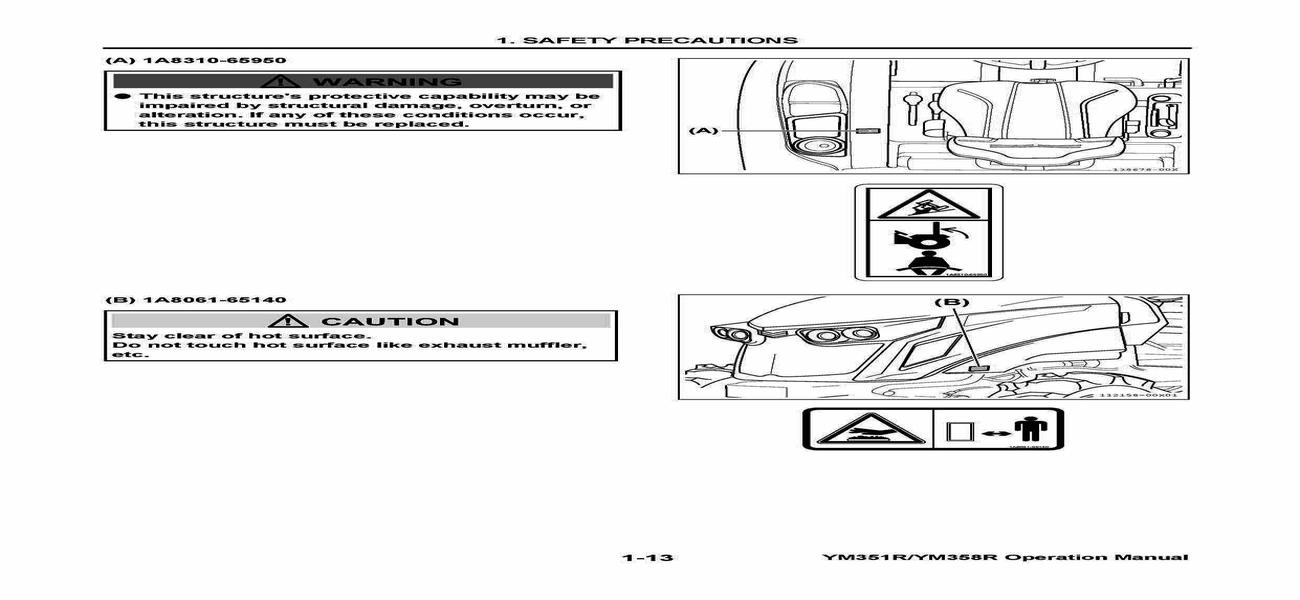

In [39]:
from IPython.display import display, HTML, Markdown

question = "Every 2 years what should we do for the safety precuations of YM358A tractor? give me details?"

# 1) get answer text
result = chain_multimodal_rag.invoke(question)

# 2) get retrieved context (including image base64)
ctx = (retriever | RunnableLambda(split_image_text_types)).invoke(question)

# 3) show image (if any) + answer
if ctx["images"]:
    display(HTML(f"""
    <div style="display:flex; gap:16px; align-items:flex-start; flex-wrap:wrap; flex-direction:column;">
      <div style="flex:1">{result}</div>
      <img src="data:image/jpeg;base64,{ctx['images'][0]}" />
    </div>
    """))
else:
    display(Markdown(result))

In [ ]:
texts